<a href="https://colab.research.google.com/github/olorunfemibabalola/Computer-Vision-Learning/blob/main/04_Lab_Homography_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and data

In [14]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

Functions to show images copied from lecture notebooks:

In [91]:
def show_img(im, ax=None, figsize=(8,8)):
    if not ax:
      _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2:
      im = np.tile(im[:,:,None], 3)
    ax.imshow(im[:,:,::-1]);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax

In [17]:
def show_imgs(ims, rows=1, figsize=(16,8)):
    _,ax = plt.subplots(rows, len(ims)//rows, figsize=figsize)
    [show_img(im,ax_) for im,ax_ in zip(ims,ax.flatten())]
    return ax

Download and unzip data from Google Drive like we did in the lectures:

In [18]:
fname = "04-lab-files.zip"
!gdown https://drive.google.com/uc?id=1wH-zgujPyGnW_01ZEPtAceNowK-bFPUJ -O {fname}
!unzip -o {fname}
!rm {fname}

Downloading...
From: https://drive.google.com/uc?id=1wH-zgujPyGnW_01ZEPtAceNowK-bFPUJ
To: /content/04-lab-files.zip
100% 4.33M/4.33M [00:00<00:00, 242MB/s]
Archive:  04-lab-files.zip
  inflating: Photograph_1.json       
  inflating: __MACOSX/._Photograph_1.json  
  inflating: inked_dye_1.JPG         
  inflating: __MACOSX/._inked_dye_1.JPG  
  inflating: Inked_dye_1.json        
  inflating: __MACOSX/._Inked_dye_1.json  
  inflating: inked_scanner_1.JPG     
  inflating: __MACOSX/._inked_scanner_1.JPG  
  inflating: Inked_scanner_1.json    
  inflating: __MACOSX/._Inked_scanner_1.json  
  inflating: photograph_1.JPG        
  inflating: __MACOSX/._photograph_1.JPG  


We have three image files and three corrsepsonding .json files:

In [46]:
!ls

inked_dye_1.JPG   inked_scanner_1.JPG	__MACOSX	  Photograph_1.json
Inked_dye_1.json  Inked_scanner_1.json	photograph_1.JPG  sample_data


The image files contain three different images of the same shoe outsole, collected using three different techniques. The .json files contain landmarks/keypoints for each of the images. Your task is to use these keypoints to 'stich' the three images together like we did in the lecture.  

In [35]:
im1, im2, im3 = map(cv2.imread, ['inked_dye_1.JPG', 'inked_scanner_1.JPG', 'photograph_1.JPG'])

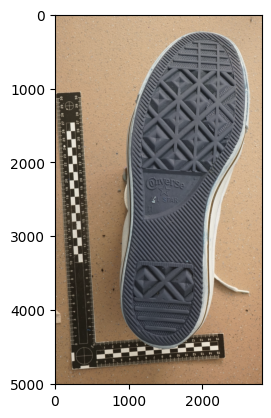

In [36]:
plt.imshow(im3)

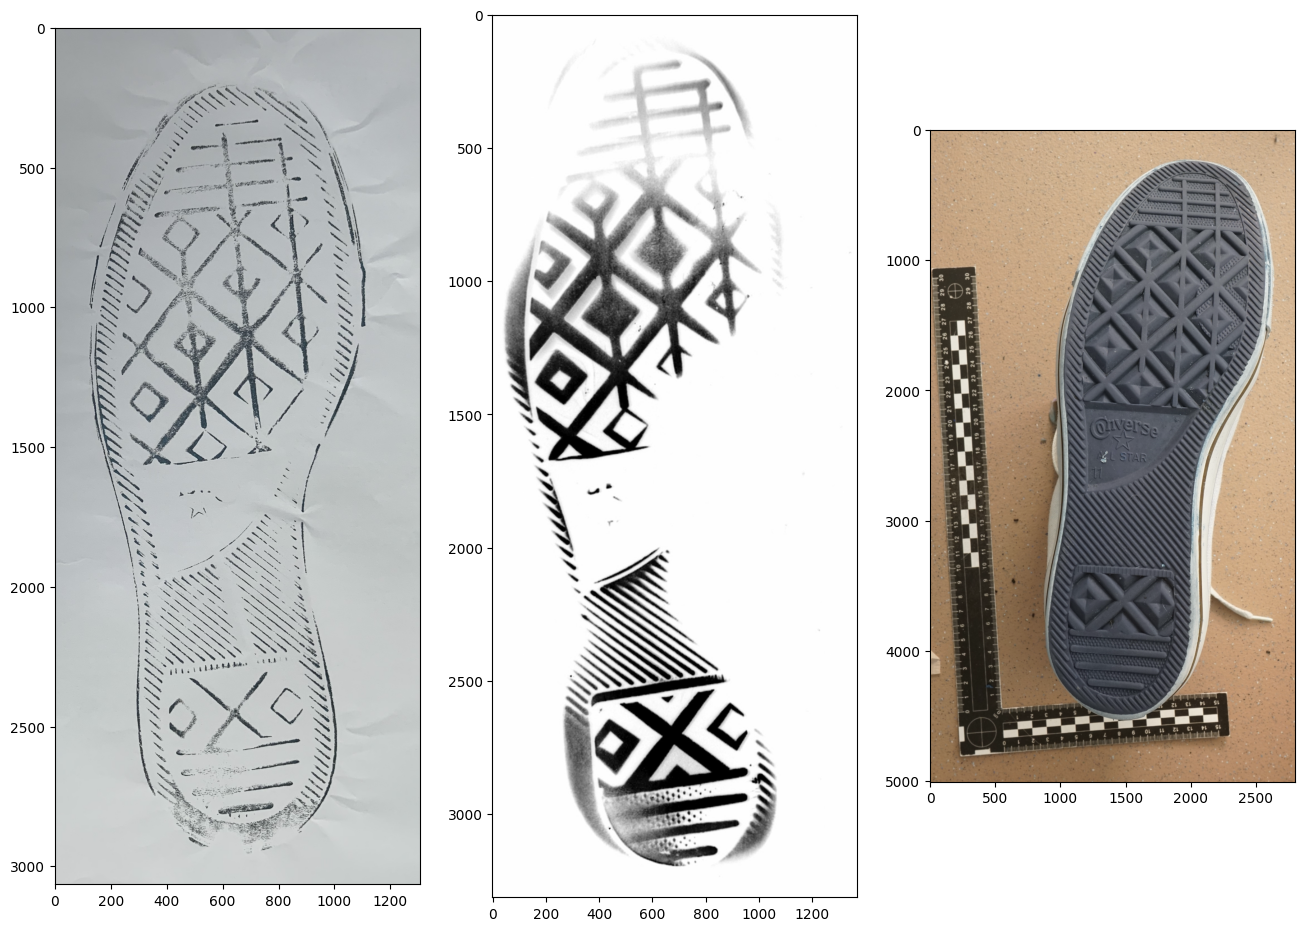

In [42]:
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(im1)
plt.subplot(1,3,2)
plt.imshow(im2)
plt.subplot(1,3,3)
plt.imshow(im3)
plt.show()

In [52]:
js1, js2, js3 = json.load(open('Inked_dye_1.json')), json.load(open('Inked_scanner_1.json')), json.load(open('Photograph_1.json'))

In [57]:
with open('Inked_dye_1.json') as j:
  file = json.load(j)
  print(file)

{'_via_settings': {'ui': {'annotation_editor_height': 25, 'annotation_editor_fontsize': 0.8, 'leftsidebar_width': 18, 'image_grid': {'img_height': 80, 'rshape_fill': 'none', 'rshape_fill_opacity': 0.3, 'rshape_stroke': 'yellow', 'rshape_stroke_width': 2, 'show_region_shape': True, 'show_image_policy': 'all'}, 'image': {'region_label': '__via_region_id__', 'region_color': '__via_default_region_color__', 'region_label_font': '10px Sans', 'on_image_annotation_editor_placement': 'NEAR_REGION'}}, 'core': {'buffer_size': 18, 'filepath': {}, 'default_filepath': ''}, 'project': {'name': 'Inked_dye_1'}}, '_via_img_metadata': {'inked_dye_1.JPG836901': {'filename': 'inked_dye_1.JPG', 'size': 836901, 'regions': [{'shape_attributes': {'name': 'point', 'cx': 639, 'cy': 2460}, 'region_attributes': {}}, {'shape_attributes': {'name': 'point', 'cx': 304, 'cy': 1155}, 'region_attributes': {}}, {'shape_attributes': {'name': 'point', 'cx': 692, 'cy': 1111}, 'region_attributes': {}}, {'shape_attributes': {'

In [58]:
js1

{'_via_settings': {'ui': {'annotation_editor_height': 25,
   'annotation_editor_fontsize': 0.8,
   'leftsidebar_width': 18,
   'image_grid': {'img_height': 80,
    'rshape_fill': 'none',
    'rshape_fill_opacity': 0.3,
    'rshape_stroke': 'yellow',
    'rshape_stroke_width': 2,
    'show_region_shape': True,
    'show_image_policy': 'all'},
   'image': {'region_label': '__via_region_id__',
    'region_color': '__via_default_region_color__',
    'region_label_font': '10px Sans',
    'on_image_annotation_editor_placement': 'NEAR_REGION'}},
  'core': {'buffer_size': 18, 'filepath': {}, 'default_filepath': ''},
  'project': {'name': 'Inked_dye_1'}},
 '_via_img_metadata': {'inked_dye_1.JPG836901': {'filename': 'inked_dye_1.JPG',
   'size': 836901,
   'regions': [{'shape_attributes': {'name': 'point', 'cx': 639, 'cy': 2460},
     'region_attributes': {}},
    {'shape_attributes': {'name': 'point', 'cx': 304, 'cy': 1155},
     'region_attributes': {}},
    {'shape_attributes': {'name': 'poin

In [84]:
def get_pts(js):
  image_id = js['_via_image_id_list'][0]
  regions = js['_via_img_metadata'][image_id]['regions']
  pts = []
  for i in range(len(regions)):
    x = regions[i]['shape_attributes']['cx']
    y = regions[i]['shape_attributes']['cy']
    pts.append([x,y])
  return np.array(pts)

In [85]:
get_pts(js1)

array([[ 639, 2460],
       [ 304, 1155],
       [ 692, 1111],
       [ 317, 2614],
       [1005, 2548],
       [ 644,  732],
       [ 595,  348],
       [ 353, 1530],
       [1018,  538],
       [ 966,  379],
       [ 776, 2795],
       [ 379, 1980]])

In [87]:
pts1, pts2, pts3 = map(get_pts, [js1, js2, js3])

In [97]:
def plot_pts(im, pts):
  im_copy = im.copy()
  for pt in pts:
    cv2.circle(im_copy, (int(pt[0]), int(pt[1])), 25, (0,255,0), -1)
  return im_copy

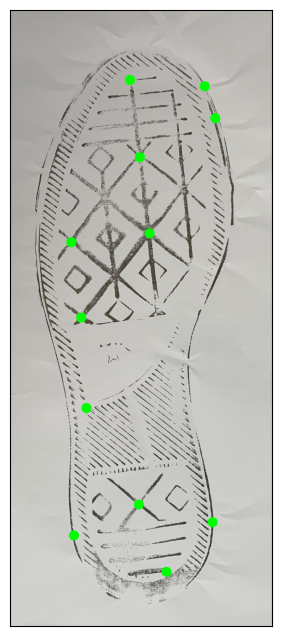

In [98]:
show_img(plot_pts(im1, pts1));

# Load and display images

In the cell below, load the three image files into variables `im1`, `im2` and `im3`. Try doing this using the `map` function if you can:



In [ ]:
#YOUR_CODE_HERE


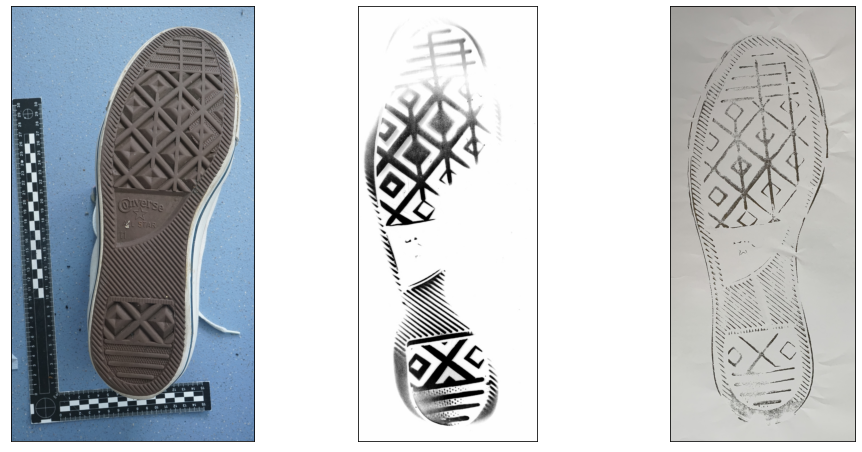

In [ ]:
show_imgs([im1,im2,im3]);

# Load and display landmarks

We now need to load the landmarks/keypoints from the *.json* files. Data annotations for computer vision datasets very often come in the *.json* format, so learning how to work with *.json* files is super important!

In the cell below, load the three *.json* files into variables `js1`, `js2` and `js3`. The relevant function you will want to use is `json.load()` from the `json` package we have imported at the top of this notebook. This function will convert data in the JSON format into a Python dictionary:


In [ ]:
#YOUR_CODE_HERE


This is what one of dictionaries you have just created should look like. Notice that it includes the name of the image file the landmarks relate to, and a collection of `shape_attributes`, which in out case are the `x` and `y` cooridnates of the landmarks/keypoints:

In [ ]:
js1

{'_via_attributes': {'file': {}, 'region': {}},
 '_via_data_format_version': '2.0.10',
 '_via_image_id_list': ['photograph_1.JPG3141683'],
 '_via_img_metadata': {'photograph_1.JPG3141683': {'file_attributes': {},
   'filename': 'photograph_1.JPG',
   'regions': [{'region_attributes': {},
     'shape_attributes': {'cx': 1506, 'cy': 3635, 'name': 'point'}},
    {'region_attributes': {},
     'shape_attributes': {'cx': 1390, 'cy': 1417, 'name': 'point'}},
    {'region_attributes': {},
     'shape_attributes': {'cx': 1919, 'cy': 1451, 'name': 'point'}},
    {'region_attributes': {},
     'shape_attributes': {'cx': 902, 'cy': 3859, 'name': 'point'}},
    {'region_attributes': {},
     'shape_attributes': {'cx': 1987, 'cy': 3927, 'name': 'point'}},
    {'region_attributes': {},
     'shape_attributes': {'cx': 1953, 'cy': 936, 'name': 'point'}},
    {'region_attributes': {},
     'shape_attributes': {'cx': 1960, 'cy': 400, 'name': 'point'}},
    {'region_attributes': {},
     'shape_attribute

Your task is now to extract the `cx` and `cy` values from each dictionary (i.e., `js1`, `js2` and `js3`) and store these in three `numpy` arrays, namely `pts1`, `pts2` and `pts3`.

In the cell below create a function called `get_pts()`, which gets one of the dictionaries like `js2` as an input and returns a `numpy` array with `x,y` cooridnates of landmarks extracted from this dictionary. You should be able to do it in 5-7 lines of code:

In [ ]:
#YOUR_CODE_HERE


Test it:

In [ ]:
get_pts(js1)

array([[1506, 3635],
       [1390, 1417],
       [1919, 1451],
       [ 902, 3859],
       [1987, 3927],
       [1953,  936],
       [1960,  400],
       [1350, 1960],
       [2509,  658],
       [2462,  495],
       [1648, 4300],
       [1207, 2760]])

In [ ]:
pts1, pts2, pts3 = map(get_pts, [js1, js2, js3])

Let's now plot the landmarks on top of each image. In the cell below, create a funcion `plot_pts(im, pts)`, which returns an image with landmarks. You can use the code from the lecture on Harris corner detector (plotting points on a chessboard) to get started:

In [ ]:
#YOUR_CODE_HERE


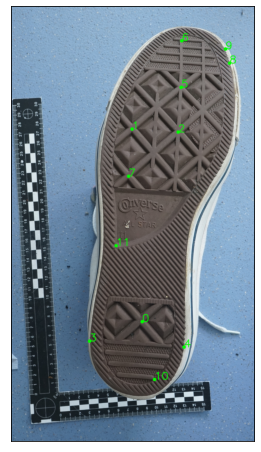

In [ ]:
show_img(plot_pts(im1, pts1));

In the cell below, use the `show_imgs` function to show all three images together with landmarks side by side:

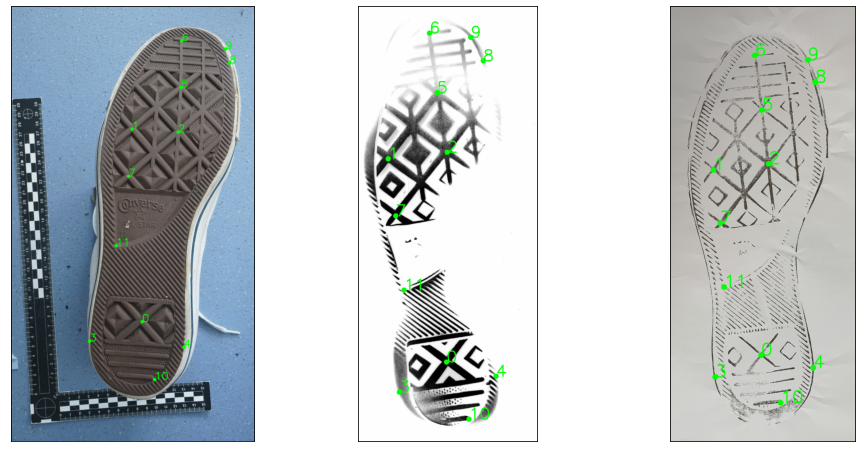

In [ ]:
#YOUR_CODE_HERE


# Homography

We will now find the homography matrix using the `cv2.findHomography()` function. We don't need to use `RANSAC` here like we did in the lectures, because our landmarks have been created manually and we hence know how they correspond across the images.

Since we are now working with three images, we need to choose one of them as 'master' and transform the remaining two onto the plane of the 'master'. If we assume that `im1` is the 'master', then we'll need to find homography mapping `im2` onto `im1` and another one mapping `im3` onto `im1`.

In the cell below, using the `cv2.findHomography()` function to calculate matrix `M1` mapping `im2` (actually `pts2`) onto `im1` (actually `pts1`). This should be a single line of code:

In [ ]:
#YOUR_CODE_HERE


In [ ]:
M1

array([[ 1.09982184e+00, -3.40263223e-01,  1.40798925e+03],
       [ 7.94202439e-02,  1.02150437e+00,  1.32526136e+02],
       [-5.06278412e-05, -5.45849579e-05,  1.00000000e+00]])

Now do the same for `pts3` and `pts1` and call the matrix `M2`:

In [ ]:
#YOUR_CODE_HERE


In [ ]:
M2

array([[ 1.28930231e+00, -3.59595107e-01,  1.28206773e+03],
       [ 2.10454715e-01,  1.24782695e+00, -2.01596544e+02],
       [-1.57470090e-09, -7.18612539e-05,  1.00000000e+00]])

All that's left to do now is to use the `cv2.warpPerspective()` function to transform `im2` and `im3` onto the plane of `im1`:

In [ ]:
#YOUR_CODE_HERE


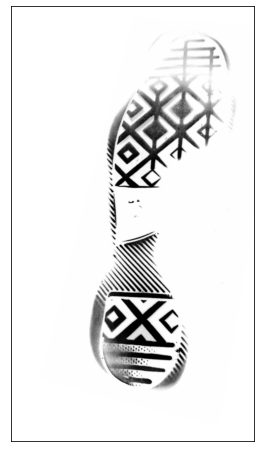

In [ ]:
show_img(out1);

In [ ]:
#YOUR_CODE_HERE


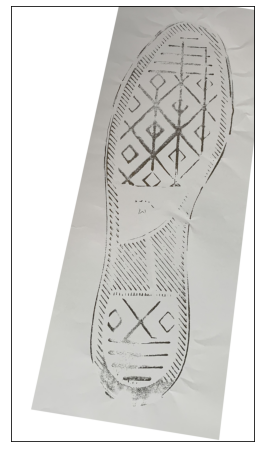

In [ ]:
show_img(out2);

Let's now blend `im1`, `out1` and `out2` into a single image:

In [ ]:
blended = 0.33*out1 + 0.33*out2 + 0.34*im1

... and enjoy the final result:

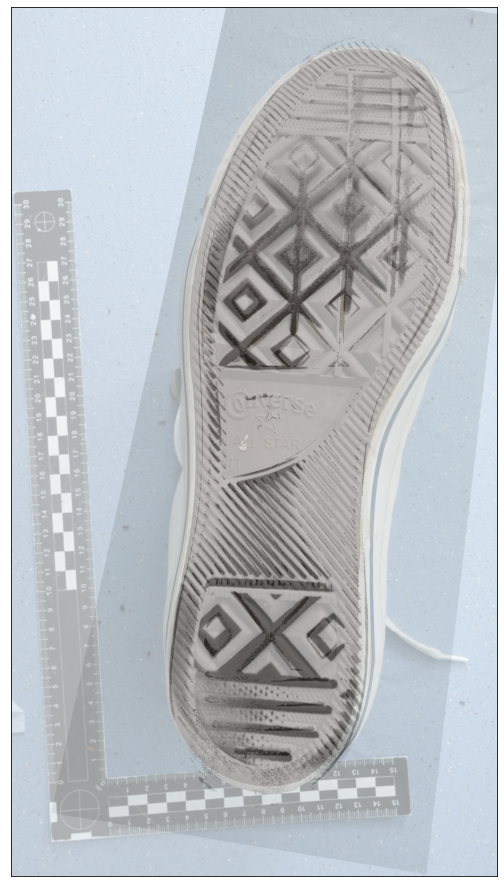

In [ ]:
show_img(blended.astype(np.uint8), figsize=(16,16));